/home/lichenglong/miniconda3/envs/troposim/lib/python3.8/site-packages/rasterio/__init__.py:277: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
2023-08-13 23:42:56.088906: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-13 23:42:56.088923: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lichenglong-linux): /proc/driver/nvidia/version does not exist
2023-08-13 23:42:56.089098: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


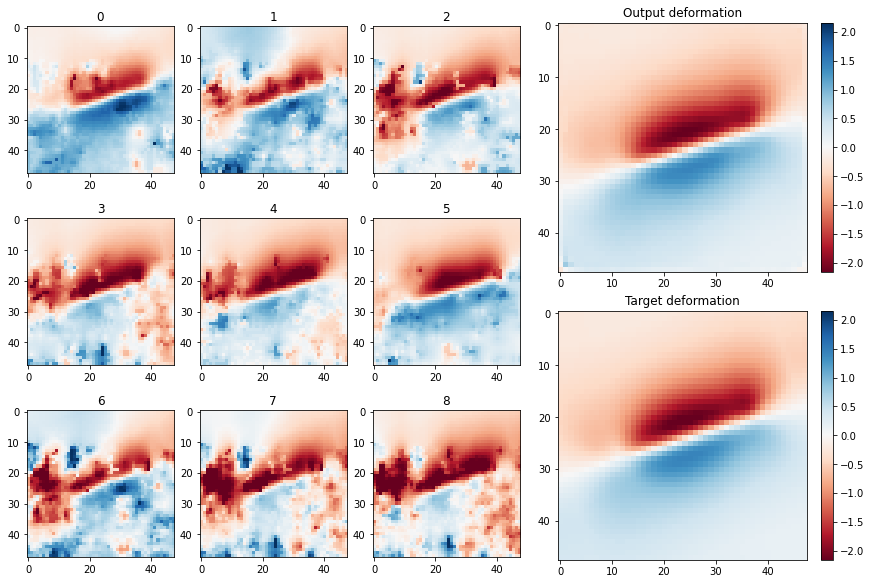

In [2]:
import h5py
import argparse
import numpy as np
import rasterio as rio
import tensorflow as tf
import matplotlib.pyplot as plt


parser = argparse.ArgumentParser(description='Sentinel Processing Wrapper')
parser.add_argument('-sim_file', type=str, dest='sim_file',
                    default='test_MPIC_data/simulated_stack_100.h5',
                    help='simulated file to predict')
parser.add_argument('-dem_file', type=str, dest='dem_file',
                    default='test_MPIC_data/maduocut_100.tif',
                    help='dem file to predict')
args = parser.parse_known_args()[0]
model_out = 'trained_denoiser/model.h5'


class MeanPctScaler:
    def __init__(self, pctile=95):
        self.percentile = pctile
        pass

    def fit(self, X):
        self.mean_ = np.average(X)
        self.scale_ = np.percentile(np.abs(X - self.mean_), self.percentile)
        return self

    def transform(self, X):
        return (X - self.mean_)/self.scale_

    def inverse_transform(self, X):
        return X * self.scale_ + self.mean_

def unstack_dem_timeseries(X):
    dems = X[..., :1, :, :, :]
    timeseries = X[..., 1:, :, :, :]
    return dems, timeseries

def stack_dem_timeseries(dems, timeseries):
    return np.concatenate((dems, timeseries), axis=1)

def plot_data_cust(X, y, output, n=9, vm=None, cmap='RdBu'):
    vm = vm or np.max(np.abs(output))
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    gs0 = fig.add_gridspec(1, 2, width_ratios=[1.5, 1])

    gs_left = gs0[0].subgridspec(3, 3)
    gs_right = gs0[1].subgridspec(2, 1)
    # Input timesteps
    for a in range(3):
        for b in range(3):
            i = 3 * a + b
            ax = fig.add_subplot(gs_left[a, b])
            ax.imshow(X[i], cmap=cmap, vmin=-vm, vmax=vm)
            ax.set_title(f"{i}")

    # Right side: output, and target deformation
    ax = fig.add_subplot(gs_right[0, 0])
    axim = ax.imshow(output, cmap=cmap, vmin=-vm, vmax=vm)
    fig.colorbar(axim, ax=ax)
    ax.set_title('Output deformation')
    ax = fig.add_subplot(gs_right[1, 0])
    axim = ax.imshow(y, cmap=cmap, vmin=-vm, vmax=vm)
    fig.colorbar(axim, ax=ax)
    ax.set_title('Target deformation')
    fig.savefig('prediction.jpg')


# Load predictive data
hf = h5py.File(args.sim_file, 'r')
defo_stack = hf['defo'][:]
strat_stack = hf['stratified'][:]
turb_stack = hf['turbulence'][:]
decor_stack = hf['decorrelation'][:]
noise = strat_stack + turb_stack + decor_stack
X_pred = defo_stack + noise*10
target_defo = defo_stack[-1]
with rio.open(args.dem_file) as src:
    dem = src.read(1).astype(np.float32)
X_pred = np.concatenate([dem[None, :, :], X_pred], axis=0)
X_pred = np.expand_dims(X_pred, 0)
X_pred = np.expand_dims(X_pred, -1)
X_pred[np.isnan(X_pred)] = 0
test_dems, test_timeseries = unstack_dem_timeseries(X_pred)
dem_scaler = MeanPctScaler().fit(test_dems)
scaled_test_dems = dem_scaler.transform(test_dems)
timeseries_scaler = MeanPctScaler().fit(test_timeseries)
scaled_test_timeseries = timeseries_scaler.transform(test_timeseries)
scaled_X_test = stack_dem_timeseries(scaled_test_dems, scaled_test_timeseries)

# Load model
autoencoder = tf.keras.models.load_model(model_out, compile=False)

# Predicition
scaled_pred = autoencoder.predict(scaled_X_test)
pred = timeseries_scaler.inverse_transform(scaled_pred)
pred = np.expand_dims(np.expand_dims(np.expand_dims(pred, axis=0), axis=0), axis=-1)
x_img = X_pred.squeeze()[1:]
targ_img = target_defo.squeeze()
y_img = pred.squeeze()
plot_data_cust(x_img, targ_img, y_img)

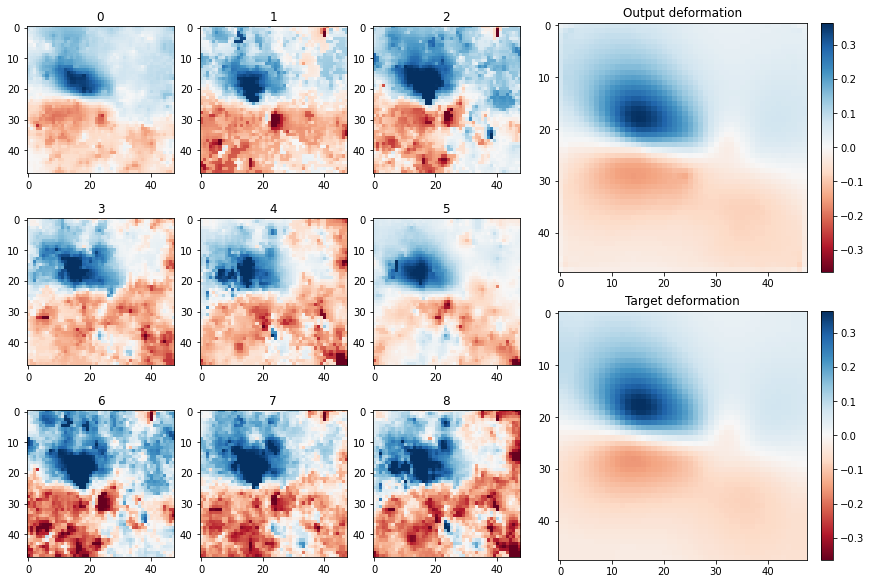

In [5]:
import h5py
import argparse
import numpy as np
import rasterio as rio
import tensorflow as tf
import matplotlib.pyplot as plt


parser = argparse.ArgumentParser(description='Sentinel Processing Wrapper')
parser.add_argument('-sim_file', type=str, dest='sim_file',
                    default='test_MPIC_data/simulated_stack_20616.h5',
                    help='simulated file to predict')
parser.add_argument('-dem_file', type=str, dest='dem_file',
                    default='test_MPIC_data/maduocut_20616.tif',
                    help='dem file to predict')
args = parser.parse_known_args()[0]
model_out = 'trained_denoiser/model.h5'


class MeanPctScaler:
    def __init__(self, pctile=95):
        self.percentile = pctile
        pass

    def fit(self, X):
        self.mean_ = np.average(X)
        self.scale_ = np.percentile(np.abs(X - self.mean_), self.percentile)
        return self

    def transform(self, X):
        return (X - self.mean_)/self.scale_

    def inverse_transform(self, X):
        return X * self.scale_ + self.mean_

def unstack_dem_timeseries(X):
    dems = X[..., :1, :, :, :]
    timeseries = X[..., 1:, :, :, :]
    return dems, timeseries

def stack_dem_timeseries(dems, timeseries):
    return np.concatenate((dems, timeseries), axis=1)

def plot_data_cust(X, y, output, n=9, vm=None, cmap='RdBu'):
    vm = vm or np.max(np.abs(output))
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    gs0 = fig.add_gridspec(1, 2, width_ratios=[1.5, 1])

    gs_left = gs0[0].subgridspec(3, 3)
    gs_right = gs0[1].subgridspec(2, 1)
    # Input timesteps
    for a in range(3):
        for b in range(3):
            i = 3 * a + b
            ax = fig.add_subplot(gs_left[a, b])
            ax.imshow(X[i], cmap=cmap, vmin=-vm, vmax=vm)
            ax.set_title(f"{i}")

    # Right side: output, and target deformation
    ax = fig.add_subplot(gs_right[0, 0])
    axim = ax.imshow(output, cmap=cmap, vmin=-vm, vmax=vm)
    fig.colorbar(axim, ax=ax)
    ax.set_title('Output deformation')
    ax = fig.add_subplot(gs_right[1, 0])
    axim = ax.imshow(y, cmap=cmap, vmin=-vm, vmax=vm)
    fig.colorbar(axim, ax=ax)
    ax.set_title('Target deformation')
    fig.savefig('prediction.jpg')


# Load predictive data
hf = h5py.File(args.sim_file, 'r')
defo_stack = hf['defo'][:]
strat_stack = hf['stratified'][:]
turb_stack = hf['turbulence'][:]
decor_stack = hf['decorrelation'][:]
noise = strat_stack + turb_stack + decor_stack
X_pred = defo_stack + noise
target_defo = defo_stack[-1]
with rio.open(args.dem_file) as src:
    dem = src.read(1).astype(np.float32)
X_pred = np.concatenate([dem[None, :, :], X_pred], axis=0)
X_pred = np.expand_dims(X_pred, 0)
X_pred = np.expand_dims(X_pred, -1)
X_pred[np.isnan(X_pred)] = 0
test_dems, test_timeseries = unstack_dem_timeseries(X_pred)
dem_scaler = MeanPctScaler().fit(test_dems)
scaled_test_dems = dem_scaler.transform(test_dems)
timeseries_scaler = MeanPctScaler().fit(test_timeseries)
scaled_test_timeseries = timeseries_scaler.transform(test_timeseries)
scaled_X_test = stack_dem_timeseries(scaled_test_dems, scaled_test_timeseries)

# Load model
autoencoder = tf.keras.models.load_model(model_out, compile=False)

# Predicition
scaled_pred = autoencoder.predict(scaled_X_test)
pred = timeseries_scaler.inverse_transform(scaled_pred)
pred = np.expand_dims(np.expand_dims(np.expand_dims(pred, axis=0), axis=0), axis=-1)
x_img = X_pred.squeeze()[1:]
targ_img = target_defo.squeeze()
y_img = pred.squeeze()
plot_data_cust(x_img, targ_img, y_img)

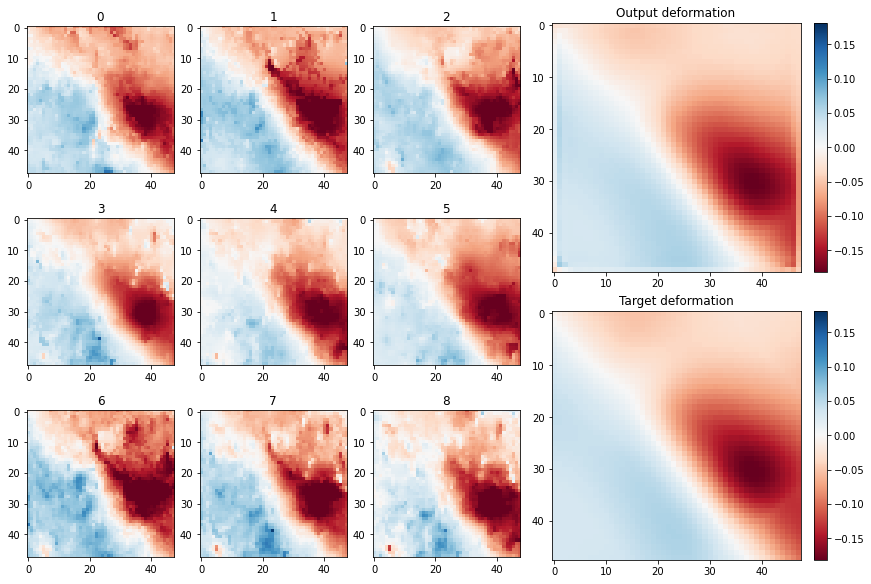

In [8]:
import h5py
import argparse
import numpy as np
import rasterio as rio
import tensorflow as tf
import matplotlib.pyplot as plt


parser = argparse.ArgumentParser(description='Sentinel Processing Wrapper')
parser.add_argument('-sim_file', type=str, dest='sim_file',
                    default='test_MPIC_data/simulated_stack_65977.h5',
                    help='simulated file to predict')
parser.add_argument('-dem_file', type=str, dest='dem_file',
                    default='test_MPIC_data/maduocut_65977.tif',
                    help='dem file to predict')
args = parser.parse_known_args()[0]
model_out = 'trained_denoiser/model.h5'


class MeanPctScaler:
    def __init__(self, pctile=95):
        self.percentile = pctile
        pass

    def fit(self, X):
        self.mean_ = np.average(X)
        self.scale_ = np.percentile(np.abs(X - self.mean_), self.percentile)
        return self

    def transform(self, X):
        return (X - self.mean_)/self.scale_

    def inverse_transform(self, X):
        return X * self.scale_ + self.mean_

def unstack_dem_timeseries(X):
    dems = X[..., :1, :, :, :]
    timeseries = X[..., 1:, :, :, :]
    return dems, timeseries

def stack_dem_timeseries(dems, timeseries):
    return np.concatenate((dems, timeseries), axis=1)

def plot_data_cust(X, y, output, n=9, vm=None, cmap='RdBu'):
    vm = vm or np.max(np.abs(output))
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    gs0 = fig.add_gridspec(1, 2, width_ratios=[1.5, 1])

    gs_left = gs0[0].subgridspec(3, 3)
    gs_right = gs0[1].subgridspec(2, 1)
    # Input timesteps
    for a in range(3):
        for b in range(3):
            i = 3 * a + b
            ax = fig.add_subplot(gs_left[a, b])
            ax.imshow(X[i], cmap=cmap, vmin=-vm, vmax=vm)
            ax.set_title(f"{i}")

    # Right side: output, and target deformation
    ax = fig.add_subplot(gs_right[0, 0])
    axim = ax.imshow(output, cmap=cmap, vmin=-vm, vmax=vm)
    fig.colorbar(axim, ax=ax)
    ax.set_title('Output deformation')
    ax = fig.add_subplot(gs_right[1, 0])
    axim = ax.imshow(y, cmap=cmap, vmin=-vm, vmax=vm)
    fig.colorbar(axim, ax=ax)
    ax.set_title('Target deformation')
    fig.savefig('prediction.jpg')


# Load predictive data
hf = h5py.File(args.sim_file, 'r')
defo_stack = hf['defo'][:]
strat_stack = hf['stratified'][:]
turb_stack = hf['turbulence'][:]
decor_stack = hf['decorrelation'][:]
noise = strat_stack + turb_stack + decor_stack
X_pred = defo_stack + noise/5
target_defo = defo_stack[-1]
with rio.open(args.dem_file) as src:
    dem = src.read(1).astype(np.float32)
X_pred = np.concatenate([dem[None, :, :], X_pred], axis=0)
X_pred = np.expand_dims(X_pred, 0)
X_pred = np.expand_dims(X_pred, -1)
X_pred[np.isnan(X_pred)] = 0
test_dems, test_timeseries = unstack_dem_timeseries(X_pred)
dem_scaler = MeanPctScaler().fit(test_dems)
scaled_test_dems = dem_scaler.transform(test_dems)
timeseries_scaler = MeanPctScaler().fit(test_timeseries)
scaled_test_timeseries = timeseries_scaler.transform(test_timeseries)
scaled_X_test = stack_dem_timeseries(scaled_test_dems, scaled_test_timeseries)

# Load model
autoencoder = tf.keras.models.load_model(model_out, compile=False)

# Predicition
scaled_pred = autoencoder.predict(scaled_X_test)
pred = timeseries_scaler.inverse_transform(scaled_pred)
pred = np.expand_dims(np.expand_dims(np.expand_dims(pred, axis=0), axis=0), axis=-1)
x_img = X_pred.squeeze()[1:]
targ_img = target_defo.squeeze()
y_img = pred.squeeze()
plot_data_cust(x_img, targ_img, y_img)